<a href="https://colab.research.google.com/github/wldopie/ESAA/blob/main/HW_220902.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 3. 분류**

## **3.1 MNIST**
  - 데이터 : 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지

In [14]:
import numpy as np
import pandas as pd

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

  
    - DESCR : 데이터셋을 설명하는 키
    - data : 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 키
    - target : 레이블 배열을 담은 키

In [4]:
X, y = mnist['data'], mnist['target']

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


  - 총 70000개의 이미지가 있고, 각 이미지에는 784개의 특성이 있다. (이미지가 28 x 28 픽셀이기 때문)

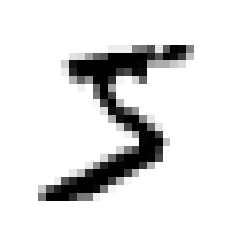

In [11]:
# 데이터셋에서 이미지 하나 확인
# 샘플의 특성 벡터를 추출해 28 x 28 배열로 크기를 바꾼 뒤, 맷플롯립의 imshow() 함수 이용

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [13]:
# 해당 이미지의 실제 레이블 확인
y[0]

'5'

  - 레이블은 문자열이다. 대부분의 머신러닝 알고리즘은 숫자를 기대하므로, y를 정수로 변환해보자.

In [15]:
y = y.astype(np.uint8)

  - MNIST 데이터셋은 앞쪽 60000개의 이미지가 훈련 세트, 뒤쪽 10000개의 이미지가 테스트 세트로 분리되어 있다. 따라서 이를 분리한다.

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

---

## **3.2 이진 분류기 훈련**

  - 문제를 단순화하여 하나의 숫자, 예를 들면 숫자 5만 식별해보도록 하자. 이는 '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 이진 분류기의 한 예이다. 분류 작업을 위해 타깃 벡터를 만들어보자.

In [17]:
y_train_5 = (y_train == 5)    # 5는 True이고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

  - 이제 분류 모델을 하나 선택해서 훈련시켜보자. 
  - `사이킷런`의 `SGDClassifier` 클래스를 이용해 확률적 경사 하강법(SGD) 분류기로 시작해보자.
    - 해당 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지닌다.
  - 이제 SGDClassifier 모델을 만들고, 전체 훈련 세트를 사용해 훈련시켜보자. 

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

  - 이제 해당 모델을 사용해 숫자 5의 이미지를 감지해보자.

In [20]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

  - 분류기는 some_digit 이미지가 5를 나타낸다고 추측했는데(True), 이는 정확한 추측이다.
  - 그럼 모델의 성능을 평가해보자.

---

## **3.3 성능 측정**

### 3.3.1 교차 검증을 사용한 정확도 측정

  - `cross_val_score()` 함수로 폴드가 3개인 k-fold 교차 검증을 사용해 SGDClassifier 모델을 평가해보자.
  - k-fold 교차 검증은 훈련 세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다.

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

  - 모든 교차 검증 폴드에 대해 정확도가 95% 이상이다.
  - 이번에는 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보자.

In [22]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y = None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)

In [23]:
# 모델의 정확도 확인
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

  - 정확도가 90% 이상이긴 하나, 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하더라도 정답을 맞출 확률이 90%이다. 
  - 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다. 특히 **불균형한 데이터셋**을 다룰 때 더욱 그렇다. 

### 3.3.2 오차 행렬

  - 분류기의 성능을 평가하는 더 좋은 방법은 **오차 행렬을 조사**하는 것이다.
    - 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다.
  - 오차 행렬을 만들기 위해서는, 실제 타깃값과 비교할 수 있도록 먼저 **예측값을 만들어야 한다.**
    - 이때, 테스트 세트를 이용해 예측을 만들 수도 있지만 여기서 사용하면 안된다. 테스트 세트는 분류기가 준비를 마치고 나서 프로젝트의 맨 마지막에 사용되기 때문이다.
    - 대신 `cross_val_predict()` 함수를 사용해보자.
    - cross_val_predict() 함수는 k-fold 교차 검증을 수행한 뒤, 각 테스트 폴드에서 얻은 예측값을 반환한다.

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

  - 이제 `confusion_matrix()` 함수를 사용해 오차 행렬을 만들어보자.

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

  - 행은 실제 클래스, 열은 예측한 클래스이다.
  - 첫 번째 행이 '5 아님' 이미지에 대한 것이므로, 53892개를 '5 아님'으로 정확하게 분류했고, 나머지 687개를 '5'라고 잘못 분류했다.
  - 두 번째 행은 '5' 이미지에 대한 것으로, 1891개를 '5 아님'으로 잘못 분류했고, 3530개를 정확히 '5'라고 분류했다.

In [27]:
y_train_perfect_predictions = y_train_5     # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 3.3.3 정밀도와 재현율

  - 위에서 살펴봤듯이, 오차 행렬이 많은 정보를 제공해주지만 가끔 더 요약된 지표가 필요할 때도 있다.
  - `정밀도` : 양성 예측의 정확도
$$정밀도 = \frac{TP}{TP + FP}$$
    - TP : True Positive (진짜 양성의 수)
    - FP : False Positive (거짓 양성의 수)

  - `재현율` : 분류기가 정확하게 감지한 양성 샘플의 비율
$$재현율 = \frac{TP}{TP + FN}$$
  - 사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공한다.

In [30]:
# 정밀도 계산
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)      # == 3530 / (3530 + 687)

0.8370879772350012

In [31]:
# 재현율 계산
recall_score(y_train_5, y_train_pred)     # == 3530 / (3530 + 1891)

0.6511713705958311

  - `F1 score` : 정밀도와 재현율의 조화 평균
$$F1 = 2*\frac{precision * recall}{precision + recall}$$
  - `f1_score()` 함수를 이용해 F1 score를 계산한다.

In [33]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프

  - 정밀도를 올리면 재현율이 줄고, 그 반대도 마찬가지이다. 이를 **정밀도/재현율 트레이드오프**라고 한다.
  - 사이킷런에서 임계값을 직접 지정할 수는 없지만, 예측에 사용한 점수는 확인할 수 있다. 
  - 분류기의 predict() 메서드 대신 `decision_function()` 메서드를 호출하면 `각 샘플의 점수를 얻을 수 있다.`
  - 이 점수를 기반으로 원하는 임계값을 정해 예측을 만들 수 있다.

In [34]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([2164.22030239])

In [36]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

  - SGDClassifier의 임계값이 0이므로, 위 코드는 predict() 메서드와 같은 결과(True)를 반환한다.
  - 이번에는 임계값을 조금 더 높여보자.

In [37]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

  - 이 결과는 임계값을 높이면 재현율이 줄어든다는 것을 보여준다.
  - 이미지가 실제로 숫자 5이고, 임계값이 0일 때는 분류기가 이를 감지했지만, 임계값을 8000으로 높이면 이를 놓치게 된다.
  - 그렇다면 적절한 임계값을 어떻게 정할 수 있을까?
    - 이를 위해서는 먼저 `cross_val_predict()` 함수를 사용해 `훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.`
    - 이때 예측 결과가 아니라 `결정 점수를 반환`받도록 지정해야 한다.

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, 
                             method = 'decision_function')

  - 이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임계값에 대해 정밀도와 재현율을 계산할 수 있다.

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

  - 이제 맷플롯립을 이용해 임계값의 함수로 정밀도와 재현율을 그릴 수 있다.

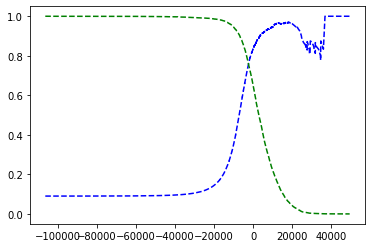

In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label = '정밀도')
  plt.plot(thresholds, recalls[:-1], 'g--', label = '재현율')
  [...]     # 임계값을 표시하고 범례, 축 이름, 그리드를 추가합니다.

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

  - 정밀도 90%를 달성하는 것이 목표라고 가정해보자. 최소한 90%의 정밀도가 되는 가장 낮은 임계값을 찾아보자.
  - `np.argmax()`는 최댓값의 첫 번째 인덱스를 반환하는 함수이다. 여기서는 첫 번째 True 값을 의미한다.

In [42]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.019499143958

  - 훈련 세트에 대한 예측을 만들기 위해, 분류기의 predict() 메서드 대신 다음 코드를 실행해보자.

In [43]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

  - 이 예측에 대한 정밀도와 재현율을 확인해보자.

In [45]:
# 정밀도
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [46]:
# 재현율
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선

  - ROC 곡선 역시 이진 분류에서 널리 사용하는 도구이다.
  - 정밀도/재현율 곡선과 매우 비슷하나, `ROC 곡선`은 `민감도(재현율)에 대한 1-특이도 그래프`이다.
  - ROC 곡선을 그리려면 먼저 `roc_curve()` 함수를 이용해 여러 임계값에서 `TPR`(진짜 양성 비율, 재현율)과 `FPR`(거짓 양성 비율)을 `계산`해야 한다.

In [48]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

  - 다음으로 맷플롯립을 사용해 TPR에 대한 FPR 곡선을 그린다.

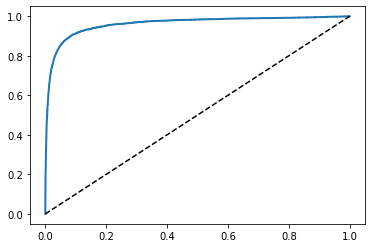

In [49]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0,1], [0,1], 'k--')     # 대각 점선
  [...]   # 축 이름, 그리드 추가

plot_roc_curve(fpr, tpr)
plt.show()

  - 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다. 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 한다. 즉, `왼쪽 위 모서리에 가까울수록 좋은 분류기`이다.

  - 곡선 아래의 면적(AUC)을 측정하면 분류기들을 비교할 수 있다. 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5이다. 사이킷런은 ROC의 AUC를 계산하는 함수를 제공한다.

In [50]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

  - 다음으로, `RandomForestClassifier`를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교해보자.
  - 먼저 훈련 세트의 샘플에 대한 점수를 얻어야 한다. 
  - `RandomForestClassifier`에는 decision_function() 메서드 대신 `predict_proba()` 메서드가 있으므로, 이를 이용한다.
    - `predict_proba()` : 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환하는 함수

In [51]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                    method = 'predict_proba')

  - roc_curve() 함수에 점수 대신 양성 클래스로 분류될 확률을 전달한다.

In [52]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

  - 이제 ROC 곡선을 그려보자. 비교를 위해 첫 번째 ROC 곡선도 함께 그려보자.

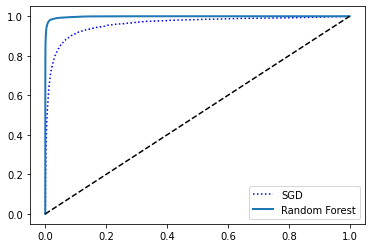

In [54]:
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'lower right')
plt.show()

  - RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 좋아 보인다. 당연히 ROC AUC 점수도 훨씬 높다.

In [55]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

---

## **3.4 다중 분류**

  - 다중 분류기는 둘 이상의 클래스를 구별할 수 있다. 
  - SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 같은 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면, 로지스틱 회귀나 서포트 벡터 머신 분류기와 같은 알고리즘은 이진 분류만 가능하다. 
  - 그러나 `이진 분류기를 여러 개 사용해 다중 클래스를 분류`하는 기법도 많다.
    - `OvR(one-versus-the-rest) 기법` : 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0부터 9까지)를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만든다. 이미지를 분류할 때, 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택한다.
    - `OvO(one-versus-one) 기법` : 각 숫자의 조합마다 이진 분류기를 훈련시킨다. 만약 클래스가 N개라면, 분류기는 N * (N-1)/2개가 필요하다. MNIST 문제에서는 총 45개의 분류기를 훈련시켜야 한다. 
    - 대부분의 이진 분류 알고리즘에서는 OvR을 선호한다.

  - 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면, 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행한다. sklearn.svm.SVC 클래스를 이용해 서포트 벡터 머신 분류기를 테스트해보자. 


In [56]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)     # y_train_5가 아니라 y_train을 사용
svm_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([5], dtype=uint8)

  - 내부에서 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고, 각각의 결정 점수를 얻어 가장 높은 클래스를 선택한다.
  - 정말 그런지 확인해보자. decision_function() 메서드를 호출하면 샘플당 10개의 점수를 반환한다. 이 점수는 클래스마다 하나씩이다.

In [57]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

  - 가장 높은 점수가 클래스 5에 해당하는 값이다.

In [58]:
np.argmax(some_digit_scores)

5

In [59]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [60]:
svm_clf.classes_[5]

5

  - 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면, OneVsOneClassifier나 OneVsRestClassifier를 사용한다. 다음 코드는 SVC 기반으로 OvR 전략을 사용하는 다중 분류기를 만든다.

In [61]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

KeyboardInterrupt: ignored

In [ ]:
len(ovr_clf.estimators_)

  - SGDClassifier를 훈련시키는 것도 간단하다.

In [62]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

KeyboardInterrupt: ignored

  - 이 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에, 별도의 OvR이나 OvO를 적용할 필요가 없다.
  - decision_function() 메서드는 클래스마다 하나의 값을 반환한다.
  - SGD 분류기가 클래스마다 부여한 점수를 확인해보자. 

In [63]:
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[-31678.79290658, -34388.21248923,  -9287.24666981,
          2236.34358166, -22158.58647678,  -1488.8262491 ,
             0.        ,      0.        ,      0.        ,
             0.        ]])

  - 이 결과에서 분류기가 예측 결과에 강한 확신을 보임을 알 수 있다. 대부분의 점수가 큰 음수이나, 클래스 5의 점수는 2236이다.
  - 이제 분류기를 평가해보자.
  - 분류기 평가에는 일반적으로 교차 검증을 사용한다. cross_val_score() 함수를 사용해 SGDClassifier의 정확도를 평가해보자.

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

  - 모든 테스트 폴드에서 85% 이상의 점수를 얻었다. 랜덤 분류기를 사용했다면 10%의 정확도를 얻었을 것이므로 이 점수가 아주 나쁘지는 않지만, 성능을 더 높일 여지가 있다.
  - 간단하게 입력의 스케일을 조정하면, 정확도를 89% 이상으로 높일 수 있다.

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

KeyboardInterrupt: ignored

---

## **3.5 에러 분석**

  - 해당 절에서는 가능성이 높은 모델을 하나 찾았다고 가정하고, 이 모델의 성능을 향상시킬 방법을 찾아보자.
  - 한 가지 방법은 만들어진 **에러의 종류를 분석**하는 것이다.
  - 먼저 오차 행렬을 살펴볼 수 있다. cross_val_predict() 함수를 이용해 예측을 만들고, 이전처럼 confusion_matrix() 함수를 호출한다.

In [65]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

NameError: ignored

  - 오차 행렬을 맷플롯립의 matshow() 함수를 사용해 이미지로 표현하면 보기에 편리하다.

In [ ]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

  - 대부분의 이미지가 올바르게 분류되었으나, 숫자 5는 다른 숫자보다 조금 더 어두워보인다. 이는 데이터셋에 숫자 5의 이미지가 적거나, 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이다.
  - 그래프의 에러 부분에 초점을 맞춰보자. 먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교한다. 

In [ ]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

  - 다른 항목은 그대로 유지하고, 주대각선만 0으로 채워서 그래프를 그려보자.

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

  - 행은 실제 클래스, 열은 예측한 클래스를 나타낸다. 
  - 클래스 8의 열이 상당히 밝으므로, 많은 이미지가 8로 잘못 분류되었음을 알 수 있다.
  - 하지만 클래스 8의 행은 대체로 어둡다. 이는 실제 8이 적절히 8로 분류되었다는 것을 말한다.
  - 이 그래프를 통해 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다는 것을 알 수 있다.

  - 3과 5의 샘플을 그려보자.

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

  - 왼쪽의 5x5 블록 두 개는 3으로 분류된 이미지이고, 오른쪽의 5x5 블록 두 개는 5로 분류된 이미지이다.
  - 분류기가 실수한 원인은 선형 모델인 SGDClassifier를 사용했기 때문이다. 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고, 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산한다. 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 된다.

---

## **3.6 다중 레이블 분류**

  - 여러 개의 이진 꼬리표를 출력하는 분류 시스템을 **다중 레이블 분류 시스템**이라고 한다. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

## **3.7 다중 출력 분류**

  - 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이다.
  - 이를 위해 이미지에서 잡음을 제거하는 시스템을 만들어보자.

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
X_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)